Import All Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

Prepare Data from CSV

In [3]:
data = pd.read_csv("merged_datasets.csv",header="infer")
data = data.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
data = data.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

Split Dataset

In [4]:
numShots = data["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = data.loc[data["SHOT_ID"]<= trainsetSize]
testdata = data.loc[data["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())



448
313
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
44351      314  4.051489  2.010944  2.685567
44352      314  4.098172  2.020867  2.768408
44353      314  4.148763  2.031621  2.852487
44354      314  4.199231  2.042348  2.933508
44355      314  4.247574  2.052623  3.014149


Normalize Data

In [ ]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

Sequence Function

In [5]:
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique():
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data) - sequence_length):
            sequence = shot_data[i:i+sequence_length]
            X.append(sequence)
            Y.append(shot_data[i+sequence_length])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Create Sequence for test and train

In [6]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)
print(X_train.dtype,Y_train.dtype)



X_test, Y_test = prepare_data(testdata, sequence_length)
print(X_test)


float64 float64
[[[4.05148948 2.01094443 2.68556715]
  [4.09817216 2.02086714 2.76840791]
  [4.14876321 2.0316206  2.85248654]
  ...
  [4.63113315 2.13415149 3.60149403]
  [4.67896177 2.14431778 3.6678993 ]
  [4.7267221  2.15446955 3.73576034]]

 [[4.09817216 2.02086714 2.76840791]
  [4.14876321 2.0316206  2.85248654]
  [4.19923076 2.0423478  2.93350778]
  ...
  [4.67896177 2.14431778 3.6678993 ]
  [4.7267221  2.15446955 3.73576034]
  [4.7706656  2.16381003 3.80076336]]

 [[4.14876321 2.0316206  2.85248654]
  [4.19923076 2.0423478  2.93350778]
  [4.24757409 2.0526235  3.01414888]
  ...
  [4.7267221  2.15446955 3.73576034]
  [4.7706656  2.16381003 3.80076336]
  [4.81584054 2.17341226 3.86779043]]

 ...

 [[8.71863564 8.55673347 3.50075686]
  [8.73822734 8.57565295 3.35063031]
  [8.75748869 8.59425342 3.19230579]
  ...
  [8.93623098 8.76686285 1.31747471]
  [8.95378298 8.78381262 1.09617086]
  [8.96872856 8.79824539 0.87064737]]

 [[8.73822734 8.57565295 3.35063031]
  [8.75748869 8.59425

Load Model If Exist Else Skip

In [7]:
lstmModel = load_model('256-272-400-4.h5')

Configure LSTM Model

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(32,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(192, activation='relu',return_sequences=True))
lstmModel.add(LSTM(64, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(100,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(100, activation='relu',return_sequences=True))
lstmModel.add(LSTM(100, activation='relu'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(192,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(224,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh',return_sequences=True))
lstmModel.add(LSTM(160, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)
lstmModel.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test))

Train model with training dataset sequence

In [ ]:
lstmModel.fit(X_train, Y_train, epochs=20, validation_data=(X_test,Y_test))

Test Model with test dataset sequence

In [ ]:
Y_pred = lstmModel.predict(X_test)
#Y_pred = scale.inverse_transform(Y_pred)


850/850 [==============================] - 13s 15ms/step


Get Mean Squared Error

583/583 [==============================] - 28s 46ms/step - loss: 0.0013
Mean Squared Error: 0.0013419374590739608
Root Mean Squared Error: 0.03663246455091386
[0.0013419374590739608]


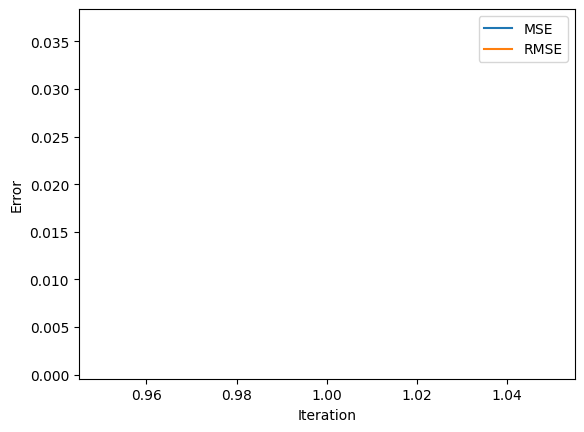

In [8]:
mse_values = []
rmse_values = []

mse = lstmModel.evaluate(X_test, Y_test)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

mse_values.append(mse)
rmse_values.append(rmse)

# Save MSE and RMSE values to a file
with open('mse_rmse_values.txt', 'a') as file:
    for mse, rmse in zip(mse_values, rmse_values):
        file.write(f'{mse},{rmse}\n')

# Read the saved MSE and RMSE values from the file
mse_values = []
rmse_values = []

with open('mse_rmse_values.txt', 'r') as file:
    for line in file:
        mse, rmse = line.strip().split(',')
        mse_values.append(float(mse))
        rmse_values.append(float(rmse))

print(mse_values)
# Plotting the MSE and RMSE values
iterations = range(1, len(mse_values) + 1)

plt.plot(iterations, mse_values, label='MSE')
plt.plot(iterations, rmse_values, label='RMSE')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

Save Model

In [ ]:
print("Saving Model")
lstmModel.save('100-100-100.h5')
print("Model Saved")

Plotting

In [ ]:
Y_test = scale.inverse_transform(Y_test)

In [ ]:
print(Y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test[:,0], Y_test[:,1], Y_test[:,2], color='b', label='Actual')
ax.scatter(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], color='r',label='Predicted')
plt.show()

Recursive Prediction

In [9]:
def recurcivePredict(dataArr,predictedTrajectory):
  predictedCord = lstmModel.predict(dataArr)
  #print(predictedCord[0][2])
  if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][14][0]:
    dataArr = np.delete(dataArr,0,1)
    dataArr = np.append(dataArr,[predictedCord],axis=1)
    predictedTrajectory = np.append(predictedTrajectory,[predictedCord],axis=1)
    return recurcivePredict(dataArr,predictedTrajectory)
  else:
    return predictedTrajectory

# def recurcivePredict(dataArr):
#   predictedCord = lstmModel.predict(dataArr)
#   print(predictedCord[0][2])
#   if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][-1][0]:
#     dataArr = np.append(dataArr,[predictedCord],axis=1)
#     return recurcivePredict(dataArr)
#   else:
#     return dataArr

# initialInput = []
# initialInput.append(testdata.iloc[40:55][['X', 'Y', 'Z']].values)
# initialInput = np.array(initialInput)


# trajectory = recurcivePredict(initialInput,initialInput)
# print(trajectory)



153
1/1 [==============================] - 0s 31ms/step


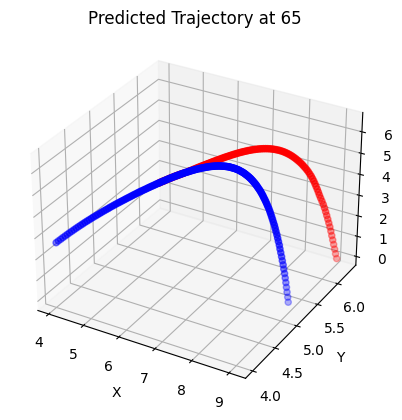

1/1 [==============================] - 0s 16ms/step


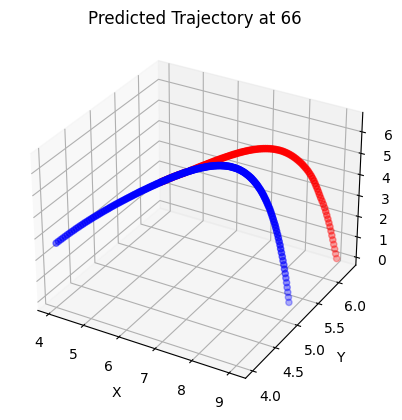

1/1 [==============================] - 0s 16ms/step


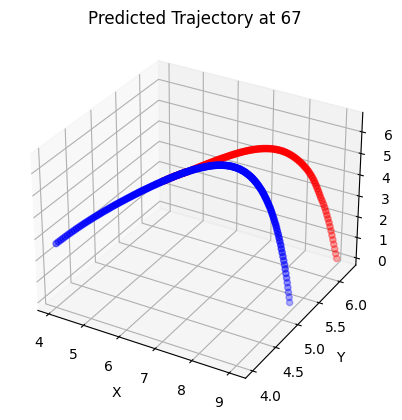

1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: 

In [10]:
def predictTrajectory(startIndex, shotid):
  testinput = []

  testinput.append(data.loc[data['SHOT_ID'] == shotid][['X', 'Y', 'Z']].values)
  count = len(testinput[0])
  print(count)
  for i in range(startIndex,count):
    testinput = np.array(testinput)
    testdata = [testinput[0,:][i-15:i]]
    testdata = np.array(testdata)
    trajectory = recurcivePredict(testdata,testdata)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Predicted Trajectory at {i}")
    ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
    ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
    plt.show()
    
    time.sleep(5)

predictTrajectory(65,417)

Nicole's attempt to move the robot.

1/1 [==============================] - 0s 24ms/step


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22028\1189537988.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  distCovered = robotspeed/distCtoP


1/1 [==============================] - 0s 32ms/step
115


C:\Users\Ryan\AppData\Local\Temp\ipykernel_22028\1189537988.py:108: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


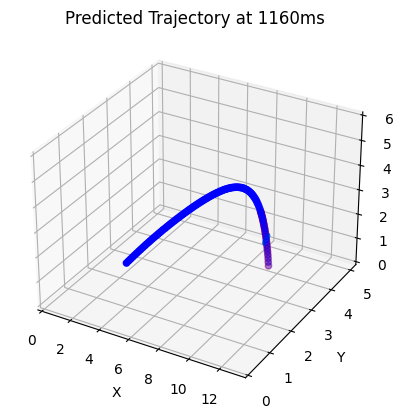

In [29]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import imageio
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

def robotMoveTo(originalPoint,ExpectedPoint):
    # print("hit")
    returnPoint = originalPoint
    r=0.02 #robot can only move 0.02m per 10 ms
    #originalPoint (x,y); ExpectedPoint (X,Y)
    angle = math.degrees(math.atan(ExpectedPoint[1]/ExpectedPoint[0])) #tan-1(Y,X)
    # x have to move +- px
    px = r*math.cos(angle)
    # y have to move +- y
    py = r*math.sin(angle)
    # x<X + , x>X -
    if(originalPoint[0]<ExpectedPoint[0]):
        returnPoint[0] = returnPoint[0]+px
    elif (originalPoint[0]>ExpectedPoint[0]):
        returnPoint[0] = returnPoint[0]-px
    # y<Y + , y>Y -
    if(originalPoint[1]<ExpectedPoint[1]):
        returnPoint[1] = returnPoint[1]+py
    elif (originalPoint[1]>ExpectedPoint[1]):
        returnPoint[1] = returnPoint[1]-py
    #return new x,y
    return returnPoint

def robotMovement(current,predicted):
    robotspeed = 0.02
    distCtoP = np.sqrt(((predicted[0]-current[0])**2)+((predicted[1]-current[1])**2))
    distCovered = robotspeed/distCtoP
    if(distCovered >= 1):
        return predicted
    else:
        newX = ((1-distCovered)*current[0]) + (distCovered*predicted[0])
        newY = ((1-distCovered)*current[1]) + (distCovered*predicted[1])
        return[newX,newY,0]


def predictTrajectory(startIndex, shotid):
    testinput = []

    testinput.append(data.loc[data['SHOT_ID'] == shotid][['X', 'Y', 'Z']].values)
    count = len(testinput[0])
    robotPostion = [10.5,2.59,1.1] #position where robot start, middle of robot service area, z = 1.1 for now
    global frames
    frames = []  # List to store animation frames
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    testinput = np.array(testinput)
    end = np.where((testinput[0,:,2]<1.0))
    for i in range(startIndex, count):
        testdata = [testinput[0, :][i - 14:i+1]]
        testdata = np.array(testdata)
        trajectory = recurcivePredict(testdata, testdata)

        #check where robot should move
        arr = trajectory[0, :, 2]
        x=np.where((arr<=1.3) & (arr>=1.0)) # max height = height+0.1, min height= 3/4 of racket's "web" (120-(28*0.75)

        predictedshot = trajectory[0][x[0]] # the point that robot should move toward, incase of many point, select the first
        #should be this formula https://math.stackexchange.com/questions/2384610/get-point-on-circumference-of-circle-in-line
        robotPostion = robotMovement(robotPostion,predictedshot[0])
        
        ax.cla()  # Clear the axis at each iteration
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
        ax.set_xlim(0, 13.4)
        ax.set_ylim(0, 5.18)
        ax.set_zlim(0, 6) #double check what is the max height of the shutter
        
        ax.set_title(f"Predicted Trajectory at {(i+1)*10}ms")
        ax.scatter(testinput[0, :, 0], testinput[0, :, 1], testinput[0, :, 2], color='b', label='Actual')
        ax.scatter(trajectory[0, :, 0], trajectory[0, :, 1], trajectory[0, :, 2], color='r', label='Predicted')
        #plot robot
        #make robot a flat circle, https://stackoverflow.com/questions/56870675/how-to-do-a-3d-circle-in-matplotlib
        # with no fill in the circle where x is position and y,z is the racket's area.
        # 1/4 of racket is 28/4 = 7cm. hence racket's area is cirle with radius of 0.035m. !!to smalll to be seen in plot
        #Circle(xy, radius)
        pCircle = Circle((robotPostion[1], robotPostion[2]), 0.2)
        ax.add_patch(pCircle)
        art3d.pathpatch_2d_to_3d(pCircle, z=robotPostion[0], zdir="x")

        # Save the current figure as an image
        fig.savefig(f"frame_{i}.png")
        # Append the image filename to the frames list
        frames.append(f"frame_{i}.png")
        
        #time.sleep(5)

        if(i == end[0][0]):
            print(end[0][0])
            break

    

predictTrajectory(15, 30)
# Create the GIF animation using the frames
with imageio.get_writer("animation.gif", mode='I', duration=1) as writer:
    for filename in frames:
        image = imageio.imread(filename)
        writer.append_data(image)

Comparing Recursive prediction

In [9]:
testinput = []
testinput.append(data.loc[data['SHOT_ID'] == 461][['X', 'Y', 'Z']].values)
testinput = np.array(testinput)
print(testinput)

[[[4.05070526 3.00265735 1.68365312]
  [4.09845164 3.00515963 1.76971068]
  [4.14823385 3.00776861 1.85123615]
  [4.19835074 3.01039512 1.93446345]
  [4.24682388 3.01293549 2.01421167]
  [4.29444564 3.01543124 2.09082923]
  [4.34479216 3.01806979 2.16907383]
  [4.39231516 3.02056037 2.24225202]
  [4.4405757  3.02308959 2.31631667]
  [4.48970458 3.02566433 2.38992806]
  [4.53797086 3.02819386 2.46098802]
  [4.5845043  3.03063257 2.53187652]
  [4.63192728 3.03311791 2.60079064]
  [4.67741745 3.03550194 2.66934972]
  [4.72596689 3.03804631 2.73838433]
  [4.77125796 3.04041992 2.80198809]
  [4.8191275  3.04292865 2.86708101]
  [4.86353947 3.04525619 2.93141033]
  [4.90979196 3.04768018 2.99339886]
  [4.95598748 3.05010118 3.05388837]
  [5.00109184 3.052465   3.11559358]
  [5.04460372 3.05474536 3.17549797]
  [5.09012844 3.05713121 3.23507084]
  [5.13619699 3.05954556 3.29251584]
  [5.1806407  3.06187476 3.35010363]
  [5.22408629 3.06415164 3.40460417]
  [5.2696617  3.06654015 3.46338072]
 

NameError: name 'trajectory' is not defined

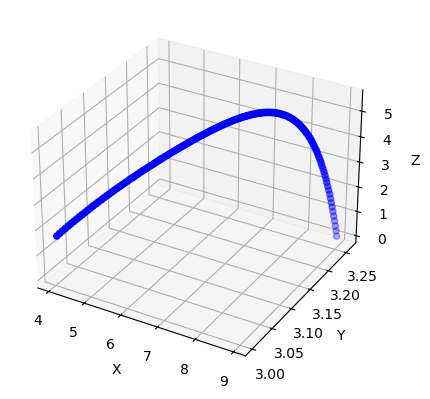

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
plt.show()